# STOR 320: Introduction to Data Science
## EDA Group 9

## Part 1: Data cleaning, merging, and visualization (6 points)

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [15]:
flights = pd.read_csv('flights.csv')
hotel = pd.read_csv('hotel_bookings.csv')

In [17]:
## column names check (1 point)
print(flights.columns)
hotel.columns

Index(['id', 'year', 'month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay',
       'arr_time', 'sched_arr_time', 'arr_delay', 'carrier', 'flight',
       'tailnum', 'origin', 'dest', 'air_time', 'distance', 'hour', 'minute',
       'time_hour', 'name'],
      dtype='object')


Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [19]:
## missing data check (1 point)
print(flights.isnull().sum())
hotel.isnull().sum()

id                   0
year                 0
month                0
day                  0
dep_time          8255
sched_dep_time       0
dep_delay         8255
arr_time          8713
sched_arr_time       0
arr_delay         9430
carrier              0
flight               0
tailnum           2512
origin               0
dest                 0
air_time          9430
distance             0
hour                 0
minute               0
time_hour            0
name                 0
dtype: int64


hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [13]:
## Outlier check (1 point)

           arr_delay      dep_delay       distance       air_time
count  327346.000000  328521.000000  336776.000000  327346.000000
mean        6.895377      12.639070    1039.912604     150.686460
std        44.633292      40.210061     733.233033      93.688305
min       -86.000000     -43.000000      17.000000      20.000000
25%       -17.000000      -5.000000     502.000000      82.000000
50%        -5.000000      -2.000000     872.000000     129.000000
75%        14.000000      11.000000    1389.000000     192.000000
max      1272.000000    1301.000000    4983.000000     695.000000
           lead_time  previous_cancellations  previous_bookings_not_canceled  \
count  119390.000000           119390.000000                   119390.000000   
mean      104.011416                0.087118                        0.137097   
std       106.863097                0.844336                        1.497437   
min         0.000000                0.000000                        0.000000   
25%   

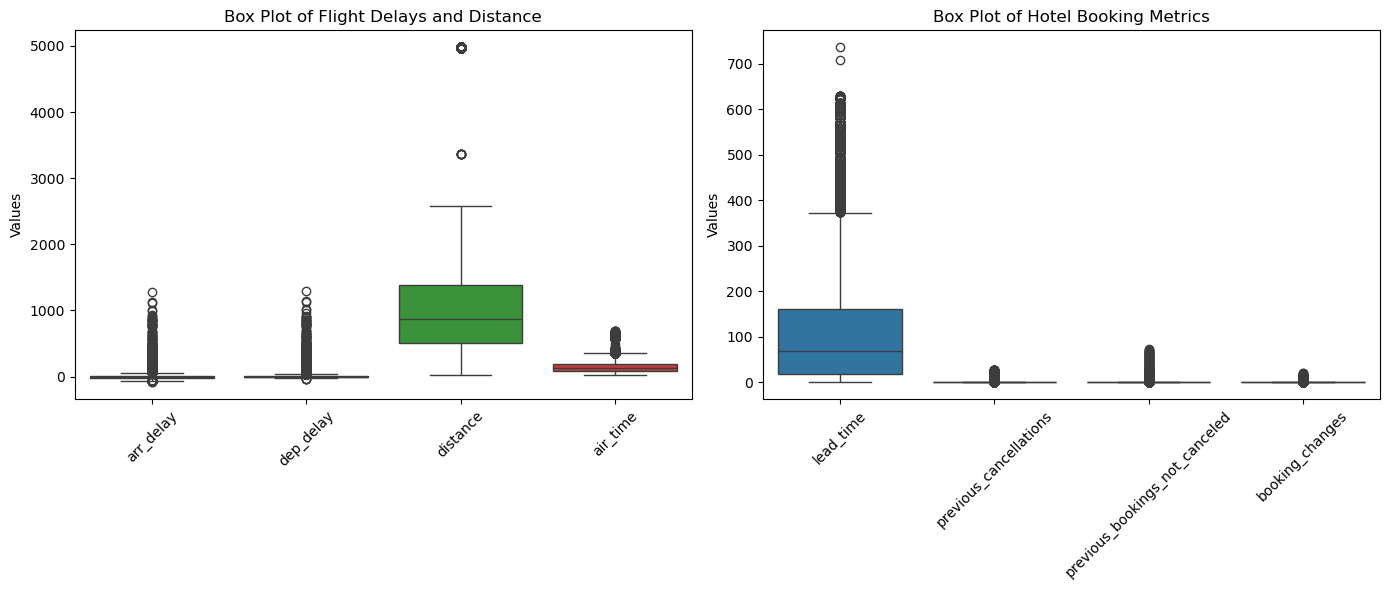

In [21]:
print(flights.describe()[['arr_delay','dep_delay','distance','air_time']])
print(hotel.describe()[['lead_time','previous_cancellations','previous_bookings_not_canceled','booking_changes']])

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=flights[['arr_delay', 'dep_delay', 'distance', 'air_time']])
plt.title('Box Plot of Flight Delays and Distance')
plt.ylabel('Values')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(data=hotel[['lead_time', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes']])
plt.title('Box Plot of Hotel Booking Metrics')
plt.ylabel('Values')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [15]:
## data merging (1 point)

In [23]:
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}
hotel['arrival_date_month_numeric'] = hotel['arrival_date_month'].map(month_mapping)

flights['month'] = flights['month'].astype(int)
flights['day'] = flights['day'].astype(int)
hotel['arrival_date_month_numeric'] = hotel['arrival_date_month_numeric'].astype(int)
hotel['arrival_date_day_of_month'] = hotel['arrival_date_day_of_month'].astype(int)
hotel['arrival_date_year'] = hotel['arrival_date_year'].astype(int)

hotel_filtered = hotel[
    (hotel['country'] == 'USA') & 
    (hotel['arrival_date_year'] == 2016) &
    (hotel['arrival_date_month_numeric'] >= 1) &
    (hotel['arrival_date_month_numeric'] <= 9) &
    (
        (hotel['arrival_date_month_numeric'] < 9) |
        (hotel['arrival_date_day_of_month'] <= 30)
    )
]
merged_data = pd.merge(
    flights, hotel_filtered, 
    left_on=['month', 'day'], 
    right_on=['arrival_date_month_numeric', 'arrival_date_day_of_month'], 
    how='inner'
)
merged_data

,id,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date_month_numeric
0,0,2013,1,1,517.0,515,2.0,830.0,819,11.0,...,8.0,NaN,0,Transient,92.0,0,1,Check-Out,2016-01-03,1
1,1,2013,1,1,533.0,529,4.0,850.0,830,20.0,...,8.0,NaN,0,Transient,92.0,0,1,Check-Out,2016-01-03,1
2,2,2013,1,1,542.0,540,2.0,923.0,850,33.0,...,8.0,NaN,0,Transient,92.0,0,1,Check-Out,2016-01-03,1
3,3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,...,8.0,NaN,0,Transient,92.0,0,1,Check-Out,2016-01-03,1
4,4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,...,8.0,NaN,0,Transient,92.0,0,1,Check-Out,2016-01-03,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694147,336774,2013,9,30,NaN,1159,NaN,NaN,1344,NaN,...,240.0,NaN,0,Transient,136.0,1,1,Check-Out,2016-10-01,9
694148,336774,2013,9,30,NaN,1159,NaN,NaN,1344,NaN,...,14.0,NaN,0,Transient,215.0,0,0,Check-Out,2016-10-03,9
694149,336775,2013,9,30,NaN,840,NaN,NaN,1020,NaN,...,240.0,NaN,0,Transient,139.0,0,0,Canceled,2016-07-23,9
694150,336775,2013,9,30,NaN,840,NaN,NaN,1020,NaN,...,240.0,NaN,0,Transient,136.0,1,1,Check-Out,2016-10-01,9


In [40]:
## data transformation, normalization, and cleaning (1 point)

In [25]:
merged_data.columns

Index(['id', 'year', 'month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay',
       'arr_time', 'sched_arr_time', 'arr_delay', 'carrier', 'flight',
       'tailnum', 'origin', 'dest', 'air_time', 'distance', 'hour', 'minute',
       'time_hour', 'name', 'hotel', 'is_canceled', 'lead_time',
       'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date',
       'arrival_date_month_numeric'],
      dtype='obje

In [27]:
merged_data['arrival_date'] = pd.to_datetime(
    merged_data['arrival_date_year'].astype(str) + '-' +
    merged_data['arrival_date_month_numeric'].astype(str) + '-' +
    merged_data['arrival_date_day_of_month'].astype(str),
    errors='coerce'
)

merged_data.drop(['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month', 'arrival_date_month_numeric'], axis=1, inplace=True)

merged_data[['arrival_date']].head()

#makes a date time column

,arrival_date
0,2016-01-01
1,2016-01-01
2,2016-01-01
3,2016-01-01
4,2016-01-01


In [29]:
merged_data['arrival_date'] = pd.to_datetime(merged_data['arrival_date'], errors='coerce')
merged_data['reservation_status_date'] = pd.to_datetime(merged_data['reservation_status_date'], errors='coerce')

#  Convers to data time

In [31]:
merged_data['dep_time_full'] = pd.to_datetime(merged_data['arrival_date'].astype(str) + ' ' + 
                                              merged_data['hour'].astype(str) + ':' + 
                                              merged_data['minute'].astype(str), errors='coerce')

# Reformats to date time

In [33]:
if 'dep_time' in merged_data.columns and 'sched_dep_time' in merged_data.columns:
    merged_data['dep_time'] = pd.to_datetime(merged_data['dep_time'], format='%H%M', errors='coerce')
    merged_data['sched_dep_time'] = pd.to_datetime(merged_data['sched_dep_time'], format='%H%M', errors='coerce')
    merged_data['dep_delay_calc'] = (merged_data['dep_time'] - merged_data['sched_dep_time']).dt.total_seconds() / 60

In [35]:
if 'arr_time' in merged_data.columns and 'sched_arr_time' in merged_data.columns:
    merged_data['arr_time'] = pd.to_datetime(merged_data['arr_time'], format='%H%M', errors='coerce')
    merged_data['sched_arr_time'] = pd.to_datetime(merged_data['sched_arr_time'], format='%H%M', errors='coerce')
    merged_data['arr_delay_calc'] = (merged_data['arr_time'] - merged_data['sched_arr_time']).dt.total_seconds() / 60

# Calculate delays based on existing columns if dep_time and sched_dep_time are present as times

In [37]:
continuous_features = ['dep_delay', 'arr_delay', 'lead_time', 'air_time', 'distance', 'days_in_waiting_list', 'adr']
scaler = StandardScaler()
merged_data[continuous_features] = scaler.fit_transform(merged_data[continuous_features])
#  Scales featues that may need tranformation

In [39]:
categorical_features = ['company', 'carrier', 
                        'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type']
merged_data = pd.get_dummies(merged_data, columns=categorical_features, drop_first=True)
#  Takes data and makes it into diffrent catigoireis for later analysis

In [41]:
binary_features = ['is_canceled', 'is_repeated_guest', 'required_car_parking_spaces']
merged_data[binary_features] = merged_data[binary_features].astype(int)
#  Turn binary data into binary (self expanitory)

In [43]:
count_features = ['previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'total_of_special_requests']
merged_data[count_features] = scaler.fit_transform(merged_data[count_features])
	
# Calculates the mean and standard deviation then applies the transformation to the data using the parameters

In [45]:
merged_data['total_guests'] = merged_data[['adults', 'children', 'babies']].sum(axis=1)
# Summing the total amounts of guests

In [47]:
merged_data['reservation_status'] = merged_data['reservation_status'].astype('category').cat.codes
# Convert regitration status to numerical codes

In [49]:
merged_data.columns

Index(['id', 'year', 'month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay',
       'arr_time', 'sched_arr_time', 'arr_delay', 'flight', 'tailnum',
       'origin', 'dest', 'air_time', 'distance', 'hour', 'minute', 'time_hour',
       'name', 'hotel', 'is_canceled', 'lead_time', 'arrival_date_week_number',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'agent', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'arrival_date',
       'dep_time_full', 'dep_delay_calc', 'arr_delay_calc', 'company_169.0',
       'company_174.0', 'company_183.0', 'company_197.0', 'company_293.0',
       'company_360.0', 'carrier_AA', 'carrier_AS', 'carrier_B6', 'carrier_DL',
       'carrier_EV', 'carrier_F9',

In [19]:
## Exploratory data visualization (1 point)

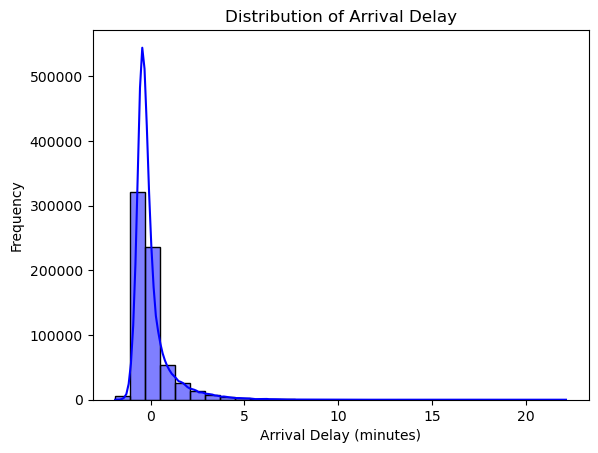

In [51]:
sns.histplot(merged_data['arr_delay'], bins=30, kde=True, color='blue')
plt.title('Distribution of Arrival Delay')
plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Frequency')
plt.show()

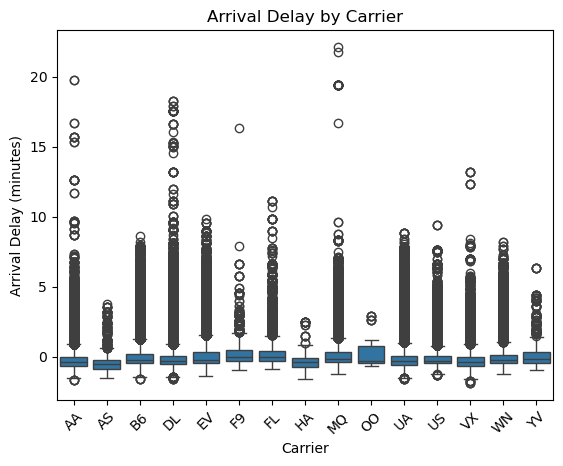

In [53]:
# select only the carrier dummy columns
carrier_cols = [col for col in merged_data.columns if col.startswith("carrier_")]
df_carrier = merged_data[carrier_cols + ['arr_delay']]
# melt the data
df_carrier_melted = df_carrier.melt(id_vars=['arr_delay'], var_name='carrier', value_name='indicator')
df_carrier_melted = df_carrier_melted[df_carrier_melted['indicator'] == 1]
df_carrier_melted['carrier'] = df_carrier_melted['carrier'].str.replace("carrier_", "")

sns.boxplot(x='carrier', y='arr_delay', data=df_carrier_melted)
plt.title('Arrival Delay by Carrier')
plt.xlabel('Carrier')
plt.ylabel('Arrival Delay (minutes)')
plt.xticks(rotation=45)
plt.show()

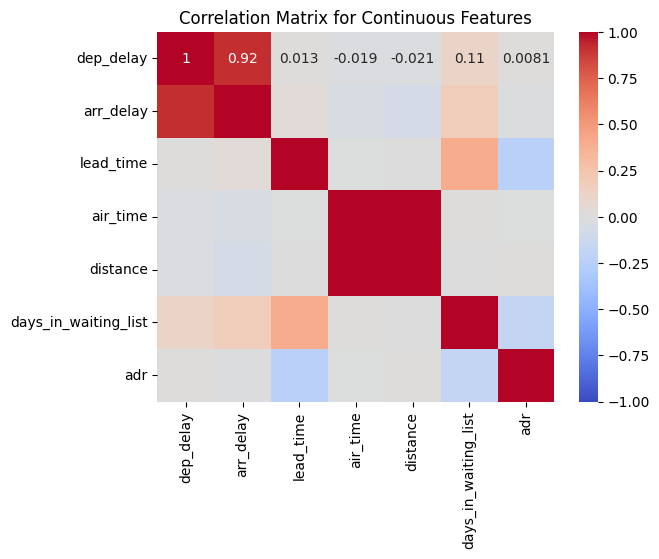

In [76]:
sns.heatmap(merged_data[continuous_features].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Continuous Features')
plt.show()


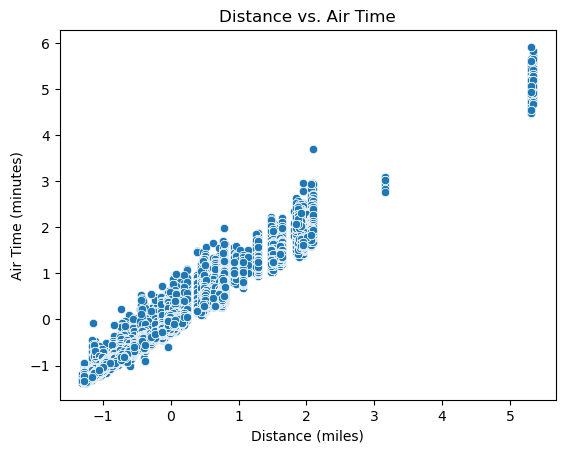

In [55]:
sns.scatterplot(x='distance', y='air_time', data=merged_data)
plt.title('Distance vs. Air Time')
plt.xlabel('Distance (miles)')
plt.ylabel('Air Time (minutes)')
plt.show()

/var/folders/v_/3h4mkrmn40l25j9sr6f4d85h0000gn/T/ipykernel_13548/1200248481.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  merged_data['arr_delay'].resample('M').mean().plot(title='Average Monthly Arrival Delay')


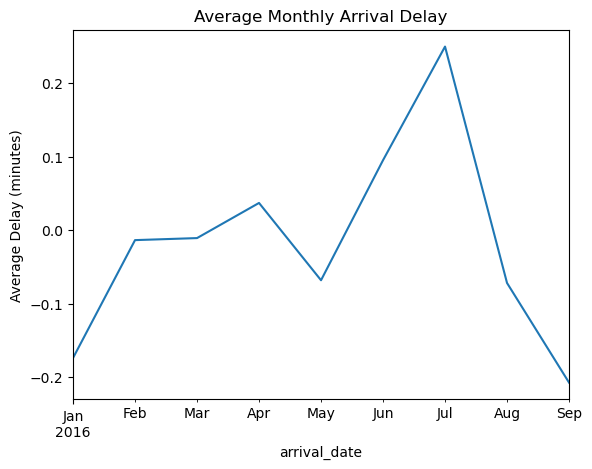

In [57]:
merged_data.set_index('arrival_date', inplace=True)
merged_data['arr_delay'].resample('M').mean().plot(title='Average Monthly Arrival Delay')
plt.ylabel('Average Delay (minutes)')
plt.show()

In [63]:
print(numeric_cols.dtypes)
print(numeric_cols.isnull().sum())
print(np.isinf(numeric_cols).sum())


dep_delay               float64
arr_delay               float64
lead_time               float64
air_time                float64
distance                float64
days_in_waiting_list    float64
adr                     float64
dtype: object
dep_delay               0
arr_delay               0
lead_time               0
air_time                0
distance                0
days_in_waiting_list    0
adr                     0
dtype: int64
dep_delay               0
arr_delay               0
lead_time               0
air_time                0
distance                0
days_in_waiting_list    0
adr                     0
dtype: int64


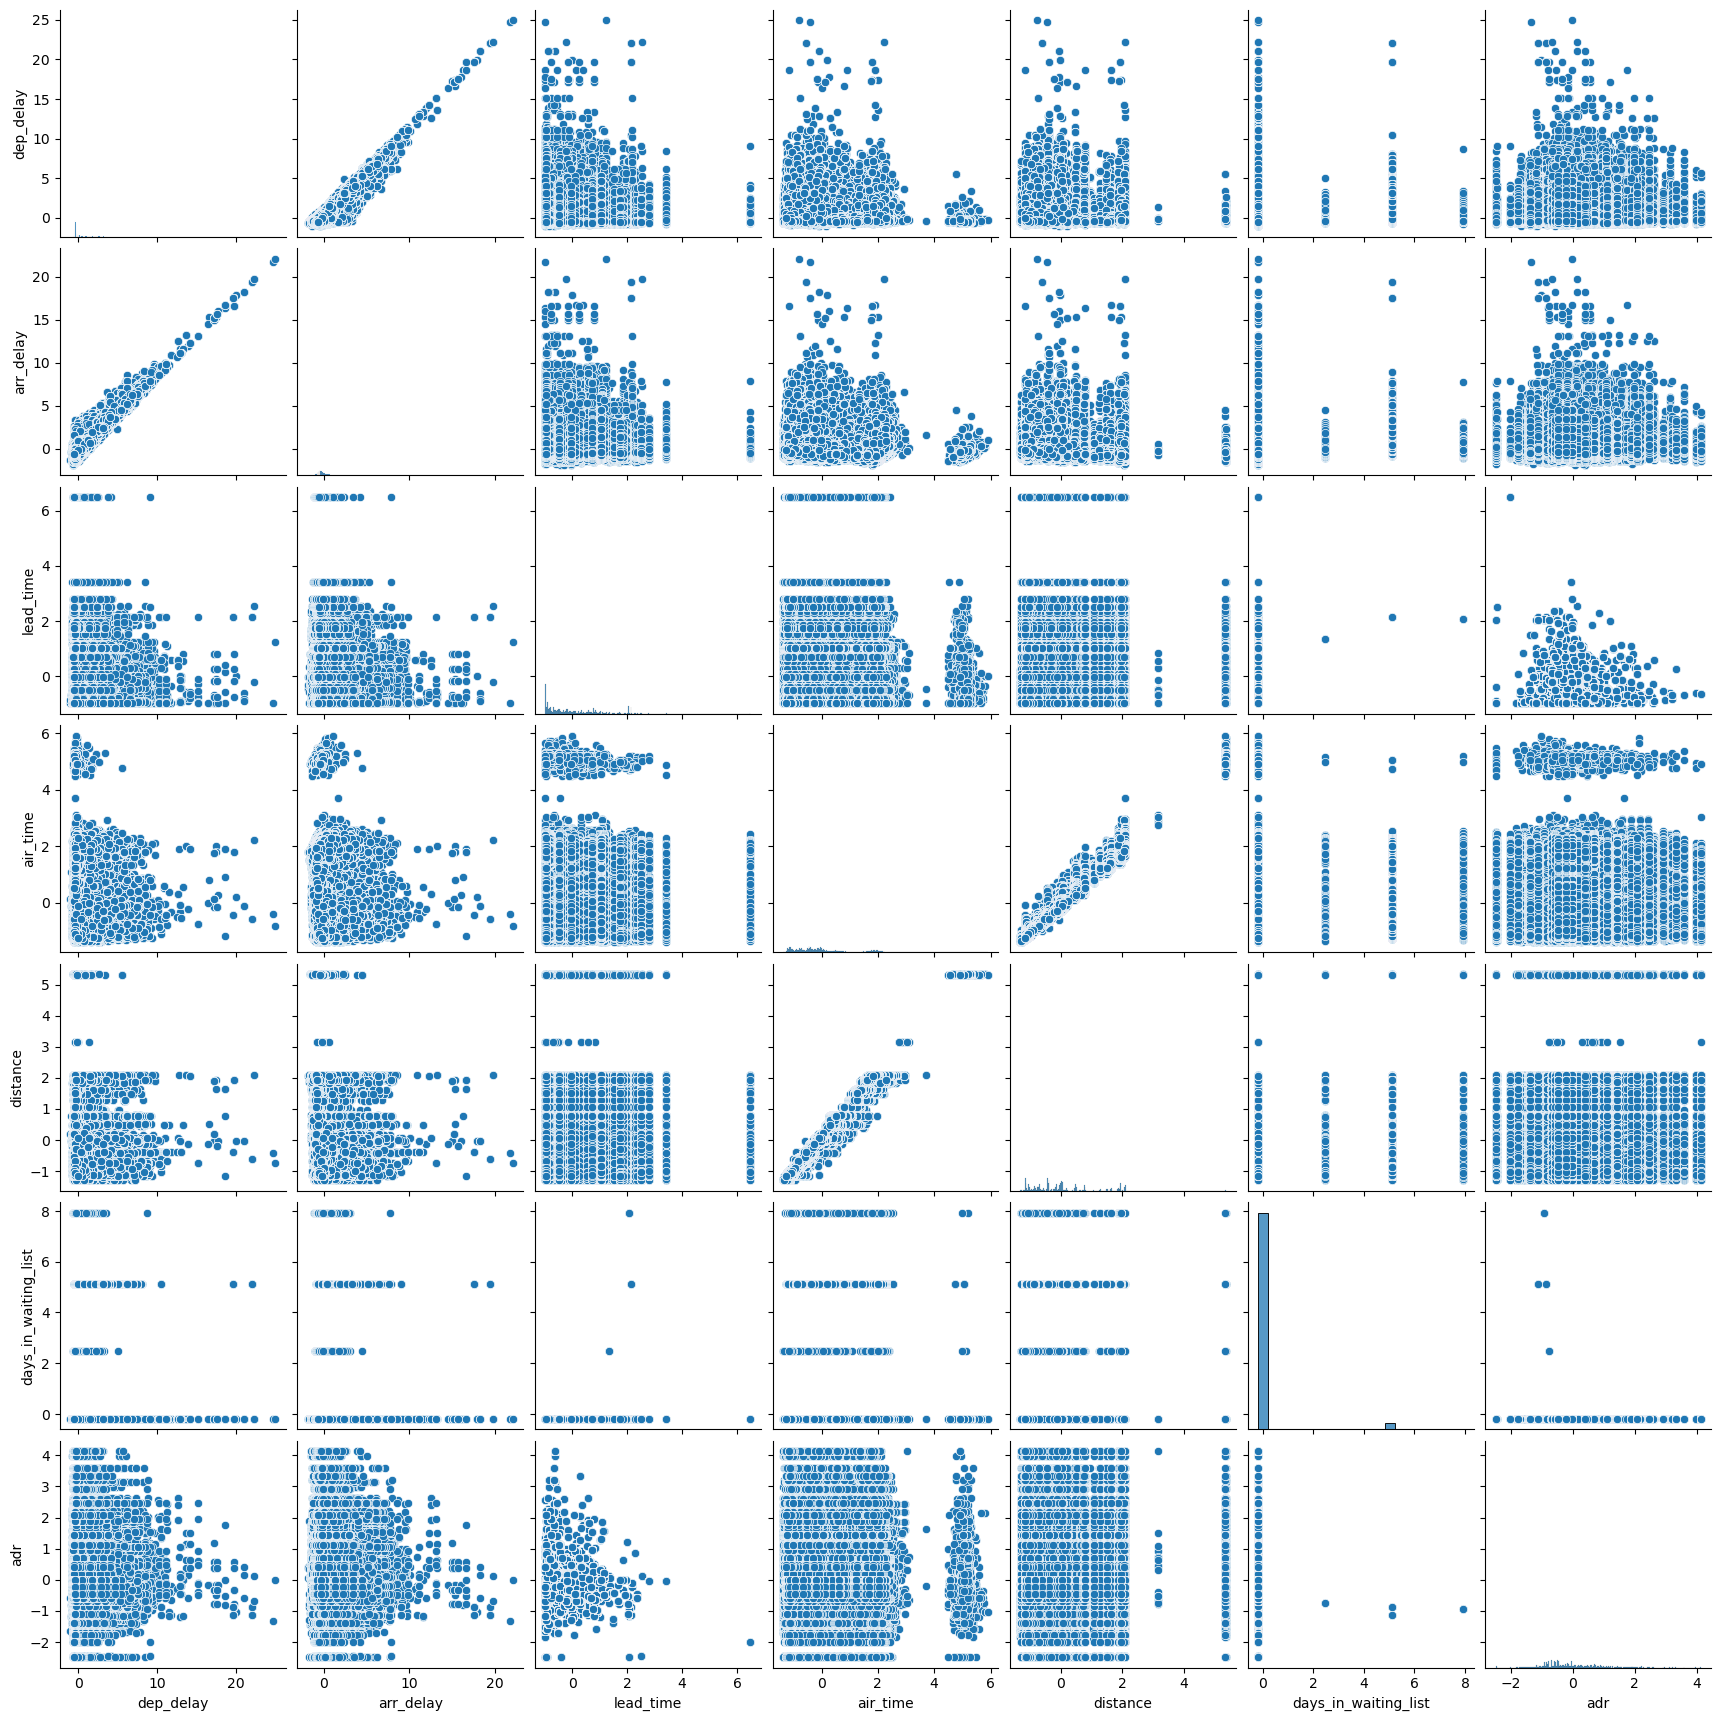

In [61]:
numeric_cols = merged_data[continuous_features].dropna()
numeric_cols_cleaned = numeric_cols.replace([np.inf, -np.inf], np.nan).dropna()
sns.pairplot(numeric_cols)

## Part 2: Answer questions from the proposals (8 points)

Each plot should be followed by a paragraph of explanation and observation.

### Creator: Rita Luo

#### Question: How do weekday and weekend patterns differ for flights and hotel stays?

In [81]:
merged_data

,id,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,...,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,total_guests
arrival_date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,0,2013,1,1,1900-01-01 05:17:00,1900-01-01 05:15:00,-0.290747,1900-01-01 08:30:00,1900-01-01 08:19:00,0.029921,...,False,False,False,False,False,False,False,False,False,2.0
2016-01-01,1,2013,1,1,1900-01-01 05:33:00,1900-01-01 05:29:00,-0.246287,1900-01-01 08:50:00,1900-01-01 08:30:00,0.208031,...,False,False,False,False,False,False,False,False,False,2.0
2016-01-01,2,2013,1,1,1900-01-01 05:42:00,1900-01-01 05:40:00,-0.290747,1900-01-01 09:23:00,1900-01-01 08:50:00,0.465300,...,False,False,False,False,False,False,False,False,False,2.0
2016-01-01,3,2013,1,1,1900-01-01 05:44:00,1900-01-01 05:45:00,-0.357437,1900-01-01 10:04:00,1900-01-01 10:22:00,-0.543986,...,False,False,False,False,False,False,False,False,False,2.0
2016-01-01,4,2013,1,1,1900-01-01 05:54:00,1900-01-01 06:00:00,-0.468588,1900-01-01 08:12:00,1900-01-01 08:37:00,-0.682516,...,False,False,False,False,False,False,False,False,False,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-30,336774,2013,9,30,NaT,1900-01-01 11:59:00,NaN,NaT,1900-01-01 13:44:00,NaN,...,False,False,True,False,False,False,False,False,False,1.0
2016-09-30,336774,2013,9,30,NaT,1900-01-01 11:59:00,NaN,NaT,1900-01-01 13:44:00,NaN,...,False,False,False,True,False,False,False,False,False,1.0
2016-09-30,336775,2013,9,30,NaT,1900-01-01 08:40:00,NaN,NaT,1900-01-01 10:20:00,NaN,...,False,False,False,True,False,False,False,False,False,2.0


In [85]:
print(merged_data.columns)

Index(['id', 'year', 'month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay',
       'arr_time', 'sched_arr_time', 'arr_delay', 'flight', 'tailnum',
       'origin', 'dest', 'air_time', 'distance', 'hour', 'minute', 'time_hour',
       'name', 'hotel', 'is_canceled', 'lead_time', 'arrival_date_week_number',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'agent', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'dep_time_full',
       'dep_delay_calc', 'arr_delay_calc', 'company_169.0', 'company_174.0',
       'company_183.0', 'company_197.0', 'company_293.0', 'company_360.0',
       'carrier_AA', 'carrier_AS', 'carrier_B6', 'carrier_DL', 'carrier_EV',
       'carrier_F9', 'carrier_FL', '

In [87]:
merged_data['arrival_date_week_number']

arrival_date
2016-01-01     1
2016-01-01     1
2016-01-01     1
2016-01-01     1
2016-01-01     1
              ..
2016-09-30    40
2016-09-30    40
2016-09-30    40
2016-09-30    40
2016-09-30    40
Name: arrival_date_week_number, Length: 694152, dtype: int64

In [95]:
merged_data.index = pd.to_datetime(merged_data.index)
merged_data['day_of_week'] = merged_data.index.dayofweek
merged_data['is_weekend'] = merged_data['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
weekday_counts = merged_data['is_weekend'].value_counts()
weekday_counts

is_weekend
Weekday    470309
Weekend    223843
Name: count, dtype: int64

In [105]:
weekday_average = 470309/5
weekend_average = 223843/2
print(weekday_average,weekend_average)

94061.8 111921.5


In [99]:
merged_data['day_name'] = merged_data.index.day_name()
merged_data['day_name']

arrival_date
2016-01-01    Friday
2016-01-01    Friday
2016-01-01    Friday
2016-01-01    Friday
2016-01-01    Friday
               ...  
2016-09-30    Friday
2016-09-30    Friday
2016-09-30    Friday
2016-09-30    Friday
2016-09-30    Friday
Name: day_name, Length: 694152, dtype: object

In [101]:
flights_per_month = merged_data.groupby('month').size().reset_index(name='num_flights')
bookings_per_month = merged_data.groupby('month').size().reset_index(name='num_bookings')
booking_and_flights_per_month = flights_per_month.merge(bookings_per_month, on=['month'], how='outer')
booking_and_flights_per_month

,month,num_flights,num_bookings
0,1,21354,21354
1,2,25645,25645
2,3,70982,70982
3,4,75195,75195
4,5,76964,76964
5,6,112342,112342
6,7,111581,111581
7,8,81865,81865
8,9,118224,118224


#### Answer:

Since we've merged hotel booking and flights, they are the same in number as shown in booking_and_flights_per_month table. After calculation, there are 470309 in total hotel booking and flights in weekdays and 223843 on weekends. The average number of booking per day for weekday is 94061.8, while the average booking per day for weekend is 111921.5. This shown that more bookings are made during weekends.

### Interpreter 1: FIRSTNAME LASTNAME

#### Question:

#### Answer:

### Interpreter 2: Daniel Xu

#### Question:

#### Answer:

In [ ]:
## Add more cells if your group has more than two interpreters

### Deliverer: Sichen Li

#### Question:

#### Answer:

## Part 3: Follow-up Questions (4 points)

### New Questions Based Off Initial Investigation

- Q1: WRITE_QUESTION_HERE
- Q2: WRITE_QUESTION_HERE

## Summary (2 points)

GIVE A 2 PARAGRAPH SUMMARY. 

PARAGRAPH 1 SHOULD DESCRIBE WHAT YOU LEARNED ABOUT YOUR DATA FROM INVESTIGATING THE INITIAL QUESTIONS. DID YOU FIND ANYTHING UNUSUAL IN YOUR DATA? DID ANYTHING SURPRISE YOU? WHICH OF THE INITIAL QUESTIONS WERE HELPFUL IN LEADING YOU TO MORE QUESTIONS?

PARAGRAPH 2 SHOULD SUMMARIZE WHAT YOU LEARNED FROM INVESTIGATING THE FOLLOW-UP QUESTIONS. WHY ARE THESE FOLLOW-UP QUESTIONS INTERESTING FOR INVESTIGATION? DESCRIBE THE TABLES/FIGURES YOU USED TO EXPLORE ANSWERS TO THESE FOLLOW-UP QUESTIONS? WHAT DID YOU LEARN FROM THE TABLES/FIGURES REGARDING THE FOLLOW-UP QUESTIONS YOU PROPOSED?